### aim: 

### date: 

In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [9]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe


def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe

def effect_OT_withRfact(ot_delta,grad_DIC_surfdeep, SO_area, mn_Revfact, mn_pCO2, PgC_mol, mn_DIC, mn_kg,\
                       dmudFe, grad_dFev, mu_L, diatconc, efratio, verbose = False):

    dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
    dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000 / SO_area
    print(dDIC_umol_L)
    dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
    
    dfco2_pgCyr_OT_TA = (-1/3) * dfco2_pgCyr_OT_DIC
    
    dDIC_Fe = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio
    dfco2_pgCyr_OT_DIC2 = dDIC_Fe * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012
    
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dfco2_pgCyr_OT_DIC2  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_OT_Fe = dfCO2_Fe * PgC_mol * SO_area    
    
    #dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    if verbose:
        print('*******')
        print(f'ot delta {ot_delta}')
        print(f'DIC ef pgC/yr: {dfco2_pgCyr_OT_DIC} TA ef pgC/yr {dfco2_pgCyr_OT_TA}')
        print(f'ecosystem pgC/yr: {dfco2_pgCyr_OT_Fe}')
        print('*******')
    
    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe



def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
    effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

    return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)



def make_BOE_output(changes_str, input_str, output_str, verbose = False):
    
    changes = xr.open_dataset(changes_str)
    inputs = xr.open_dataset(input_str)
    savenam = output_str
    print(f'making {savenam}')
    
    datar = np.zeros([3,5,6,2,2])
    sigar = np.zeros([3,5,6,2,2])
    data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
    {'units': '/yr',
    'long_name':''}),
                 'sig':(['period', 'season', 'quantity', 'forcing','scenario'], sigar,
    {'units': '/yr',
    'long_name':''}),
    }
    # define coordinates
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                          'CO2_OT_phys_chem','CO2_MLD_bio',\
                                          'CO2_OT_bio','CO2_tot']),
              'forcing': (['forcing'], ['ghg','ozone']),
              'scenario': (['scenario'], ['ssp1','ssp3']),

             }
    attrs = {'made in':'scratch/BOE-SOcarbon/sketch-refactor.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ###constants
    efratio = 0.5
    PgC_mol = 1.2e-14 # pgC/mol
    SO_area = 4.67e13#5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask

    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']
    forcingar = ['ghg','ozone']
    scenarioar = ['ssp1','ssp3']

    for p in periodar:
        tpe = int(p[0:4])
        for s in seasonar:
            for f in forcingar:
                for sc in scenarioar:

                    sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                    mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                    ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  

                    sst_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values # / decade to / 50 yrs  
                    mld_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  
                    ot_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  


                    if verbose:
                        print(f'{p} (starts {tpe}), {s}, {f}, {sc}')
                        print(f'---temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                        print(f'---temp sig {sst_sig}, mld sig {mld_sig}, ot sig {ot_sig}')

                    mn_kg = inputs.mn_kg.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_pCO2 = inputs.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dDICdz = inputs.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_Revfact = inputs.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_DIC_surfdeep = inputs.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    diatconc = inputs.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFedz = inputs.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFev = inputs.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    dmudFe = inputs.dmudFe.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_DIC = inputs.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mu_L = inputs.mu_L.loc[{'period':p, 'season':s, 'scenario': sc }].values 


                    CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                    dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                    give_me_summary(mn_kg,mn_pCO2,sst_t,PgC_mol,SO_area,\
                    mld_t, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_t,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)


                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = CO2_SST
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = CO2_tot

                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = sst_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = np.min([sst_sig,ot_sig,mld_sig])


            if verbose:
                print()
                print()

    ds.to_netcdf(savenam)
    print('done calculations')
    
    return ds


In [10]:
verbose = False
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
#changes = xr.open_dataset(changes_str)
# input_str = './data/BOE-inputs/BOE-INPUT-CLQtest.nc'
# output_str = './data/BOE-inputs/BOE-OUTPUT-CLQtest.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

# input_str = './data/BOE-inputs/BOE-INPUT-MEDUSA.nc'
# output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

input_str = './data/BOE-inputs/BOE-INPUT-OBS.nc'
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS.nc'
pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

making ./data/BOE-inputs/BOE-OUTPUT-OBS.nc
done calculations


In [11]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)


def make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc = '', save = False):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1
    fig, axs = plt.subplots(2,3, figsize=(13*fact, 8*fact), \
                            facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.5)
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.45; tlw = 2; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp3','ssp3']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*1,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                           edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                

    
        axs[i].set_xticks([1,3])
        axs[i].set_xlim([0,4])
        if i == 0:
            axs[i].set_xticklabels(['GHG effect','ozone effect'])
            axs[i].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i].set_xticklabels(['',''])
        axs[i].set_title(f'{p}')
        axs[0].set_ylabel('pgC yr$^{-1}$')
        axs[i].axhline(y=0, color = 'k')
        
        
        
        for i in range(0,6):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i].set_ylim([-0.2,0.5])
            if (i%3 == 2):
                t = 'c'    
                axs[i].set_ylim([-0.15,0.15])
                if tssp == 'ssp3':
                    axs[i].set_ylim([-0.15,2.2])
        
        
    for i in range(0,3):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = ['ssp1','ssp1']
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i+3].bar(ind+tw*1,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i+3].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i+3].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i+3].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                           edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i+3].bar(ind+tw,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i+3].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i+3].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i+3].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                

    
        axs[i+3].set_xticks([1,3])
        axs[i+3].set_xlim([0,4])
        if i == 0:
            axs[i+3].set_xticklabels(['GHG effect','ozone effect'])
            axs[i+3].tick_params(axis="x",direction="in", pad=-15)
        if i != 0:
            axs[i+3].set_xticklabels(['',''])
            
        #axs[i+3].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC yr$^{-1}$')
        axs[i+3].axhline(y=0, color = 'k')
        
        
        
        for i in range(0,3):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i+3].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i+3].set_ylim([-0.2,0.5])
            if (i%3 == 2):
                t = 'c'    
                #axs[i+3].set_ylim([-0.15,0.15])
                #if tssp == 'ssp3':
                axs[i].set_ylim([-0.25,2.2])
            axs[i+3].tick_params(axis='x', which='both', length=0.1)
            axs[i].tick_params(axis='x', which='both', length=0.1)
                
    fs = 13    
#     axs[0].text(2.6, 0.05, 'total', color = 'k', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2, 0.04, 'OT', color = 'r', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*1, -0.142, 'SST', color = 'b', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*2, 0.25, 'MLD', color = 'y', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*3, -0.1, 'ECO', color = 'g', rotation = 0, fontsize = fs, fontweight = 'bold')
    
    for i in range(2):
        for j in range(3):
            print(i*3+j)
            ax = axs[i*3+j]
            if i < 2:  # For the first two rows, position normally
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25, 0.4, 0.2])
            else:  # For the last two rows, shift downwards to create space
                ax.set_position([0.1 + j*0.5, 0.5 - i*0.25 - 0.1, 0.4, 0.2]) 


    #axs[2].legend(bbox_to_anchor = [1,0.95], fontsize = 10)
    #plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n {tssp}, data source = {valuedesc}')
#     plt.tight_layout()

    fig.text(x = 0.25, y = 0.97, s = 'Ozone and GHG Effects on Carbon Sink, SSP3', fontsize = 20)
    fig.text(x = 0.25, y = 0.4937, s = 'Ozone and GHG Effects on Carbon Sink, SSP1', fontsize = 20)
    fig.subplots_adjust(hspace=0.3) # Adjust the horizontal space

    if save:
        print(f'saved figure at {fnam_str}')
        plt.savefig(fnam_str)
    

In [22]:
w = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')
w2 = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-OBS.nc')
w2

<xarray.Dataset>
Dimensions:            (period: 3, scenario: 2, season: 5)
Coordinates:
  * period             (period) object '1950-2000' '2000-2050' '2050-2100'
  * season             (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
  * scenario           (scenario) object 'ssp1' 'ssp3'
Data variables: (12/13)
    grad_dFedz         (period, season, scenario) float64 ...
    grad_dFev          (period, season, scenario) float64 ...
    mu_L               (period, season, scenario) float64 ...
    dmudFe             (period, season, scenario) float64 ...
    diatconc           (period, season, scenario) float64 ...
    mn_kg              (period, season, scenario) float64 ...
    ...                 ...
    mn_Revfact         (period, season, scenario) float64 ...
    mn_DIC             (period, season, scenario) float64 ...
    mn_TA              (period, season, scenario) float64 ...
    mn_pCO2            (period, season, scenario) float64 ...
    grad_dDICdz        (period, season, scenario) float64 ...
    grad_DIC_surfdeep  (period, season, scenario) float64 ...
Attributes:
    made in:  BOE-SO-carbon/input-nc-for-BOEcalc-revised.ipynb
    desc:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0
1
2
3
4
5
saved figure at ./data/BOE-inputs/BOE-OUTPUT-OBS.jpg


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


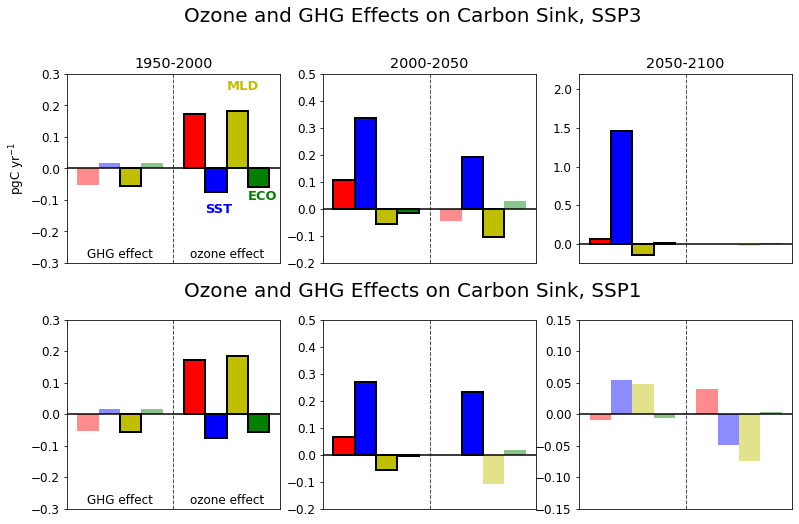

In [12]:
# output_str = './data/BOE-inputs/BOE-OUTPUT-CLQtest.nc'
# valuedesc = 'CLQ-test'
# tssp = 'ssp1'; 
# fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-CLQtest.jpg'
# make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc, True)

####
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS.nc'
valuedesc = 'CLQ-test'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-OBS.jpg'
make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc, True)

# ####
# output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA.nc'
# valuedesc = 'CLQ-test'
# tssp = 'ssp1'; 
# fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-MEDUSA.jpg'
# make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc, True)

0
1
2
3
4
5
saved figure at ./data/BOE-inputs/BOE-OUTPUT-OBS.jpg


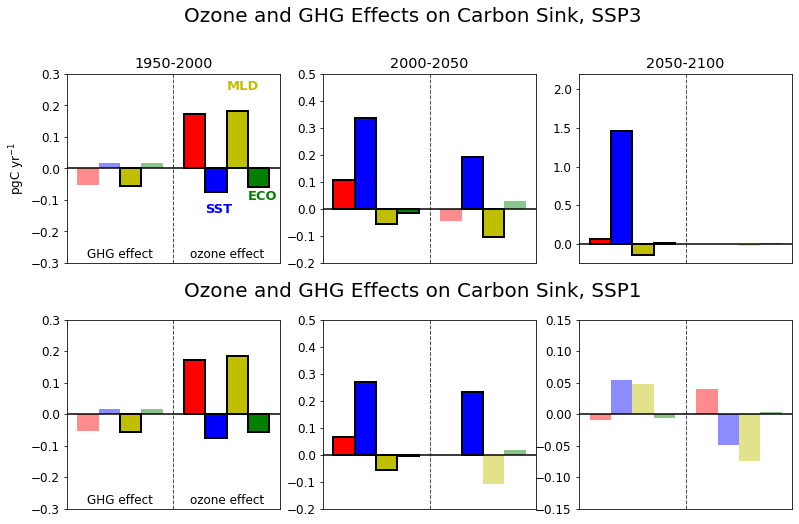

In [13]:
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS.nc'
valuedesc = 'CLQ-test'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-OBS.jpg'
make_boe_summary_graph_bothssp_slide(output_str, fnam_str, tssp, valuedesc, True)

In [14]:
ds_clq = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-CLQtest.nc')
ds_medusa = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-MEDUSA.nc')
ds_obs = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')

df = ds_obs.to_dataframe().to_csv('./data/BOE-inputs/BOE-OUTPUT-OBS.csv')
df = ds_medusa.to_dataframe().to_csv('./data/BOE-inputs/BOE-OUTPUT-MEDUSA.csv')
df = ds_clq.to_dataframe().to_csv('./data/BOE-inputs/BOE-OUTPUT-CLQtest.csv')

### one SSP, all year

In [15]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)


def make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc = '', save = False):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1
    fig, axs = plt.subplots(5,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.45; tlw = 2; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = [tssp,tssp]
        inds = [0.4,2.4]#,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                            edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*1,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 2, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.7)

            else:
#                 axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
#                           edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*2,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*3,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
#                 axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
#                 axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
#                 axs[i].axvline(x = 2.5, linestyle = '-', linewidth = 2, color = 'grey')
#                 axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')




        axs[i].set_xticks([1,3])
        axs[i].set_xlim([0,4])
        if i == 0:
            axs[i].set_xticklabels(['GHG effect','ozone effect'])
        if i != 0:
            axs[i].set_xticklabels(['',''])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC yr$^{-1}$')
        axs[i].axhline(y=0, color = 'k')
        
        for i in range(0,15):
            t = 'z'
            if (i%3 == 0):
                t = 'a'
                axs[i].set_ylim([-0.3,0.3])
            if (i%3 == 1):
                axs[i].set_ylim([-0.2,0.5])
#             if (i%3 == 2):
#                 t = 'c'    
#                 axs[i].set_ylim([-0.15,0.15])
#                 if tssp == 'ssp3':
#                     axs[i].set_ylim([-0.15,2.2])
                
    fs = 13    
#     axs[0].text(2.6, 0.05, 'total', color = 'k', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2, 0.08, 'OT', color = 'r', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*1, -0.22, 'SST', color = 'b', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*2, 0.2, 'MLD', color = 'y', rotation = 0, fontsize = fs, fontweight = 'bold')
    axs[0].text(2.2+tw*3, -0.1, 'ECO', color = 'g', rotation = 0, fontsize = fs, fontweight = 'bold')
    
    
    #axs[2].legend(bbox_to_anchor = [1,0.95], fontsize = 10)
    #plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n {tssp}, data source = {valuedesc}')
    plt.tight_layout()
    if save:
        print(f'saved figure at {fnam_str}')
        plt.savefig(fnam_str)
    



saved figure at ./data/BOE-inputs/BOE-OUTPUT-OBS-ssp1.jpg
saved figure at ./data/BOE-inputs/BOE-OUTPUT-OBS-ssp3.jpg


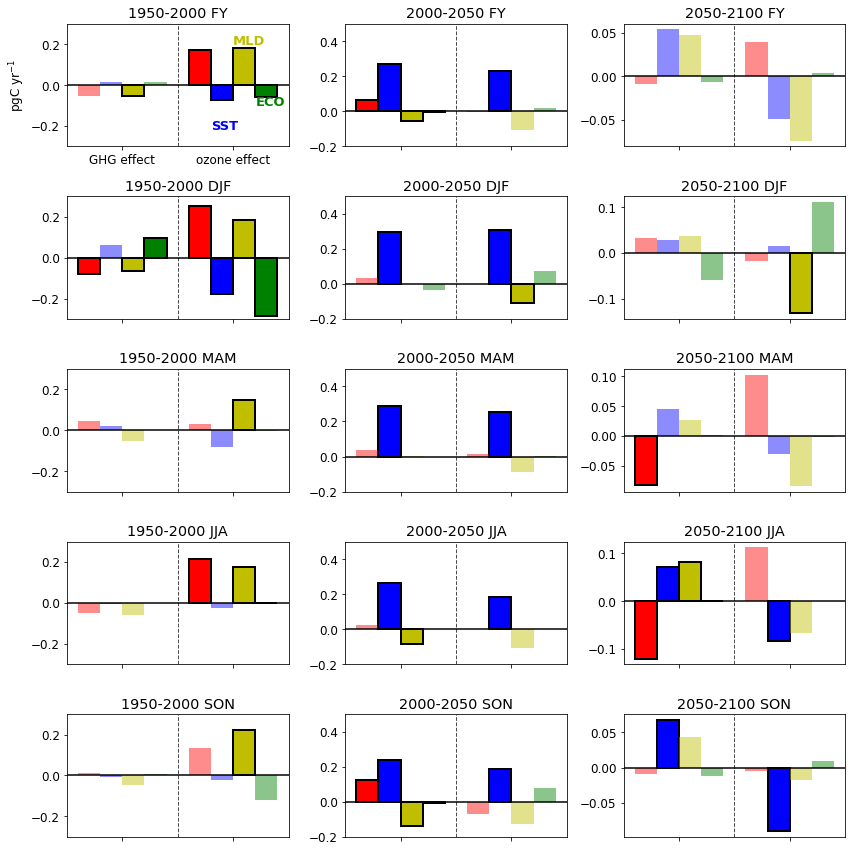

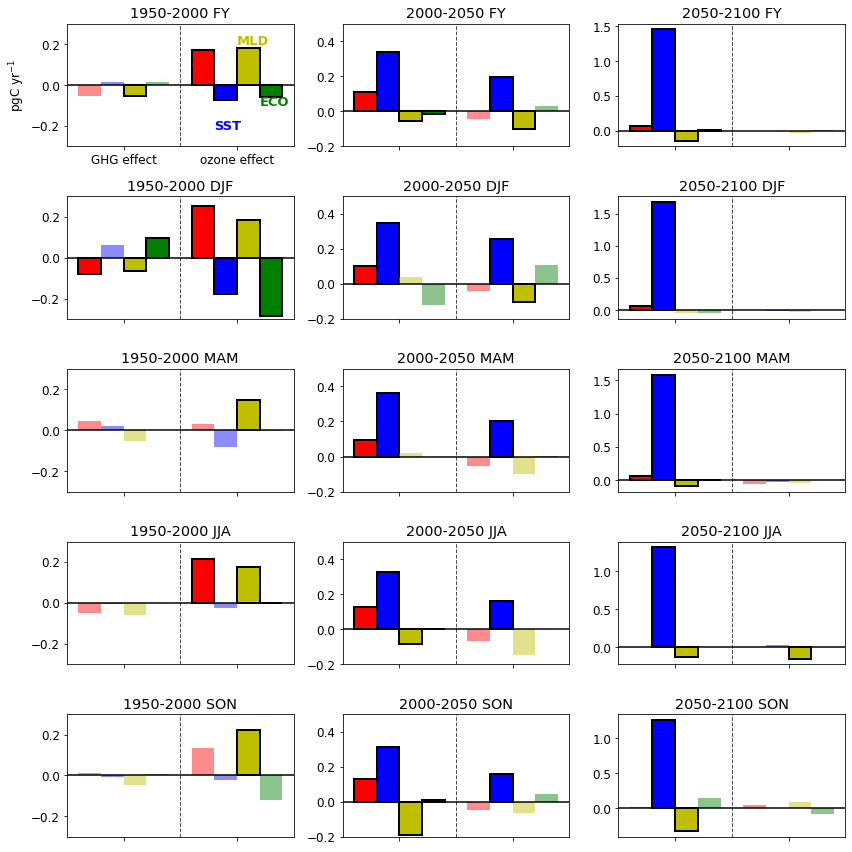

In [16]:
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS.nc'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-OBS-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)
tssp = 'ssp3'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-OBS-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)

saved figure at ./data/BOE-inputs/BOE-OUTPUT-CLQtest-ssp1.jpg
saved figure at ./data/BOE-inputs/BOE-OUTPUT-CLQtest-ssp3.jpg


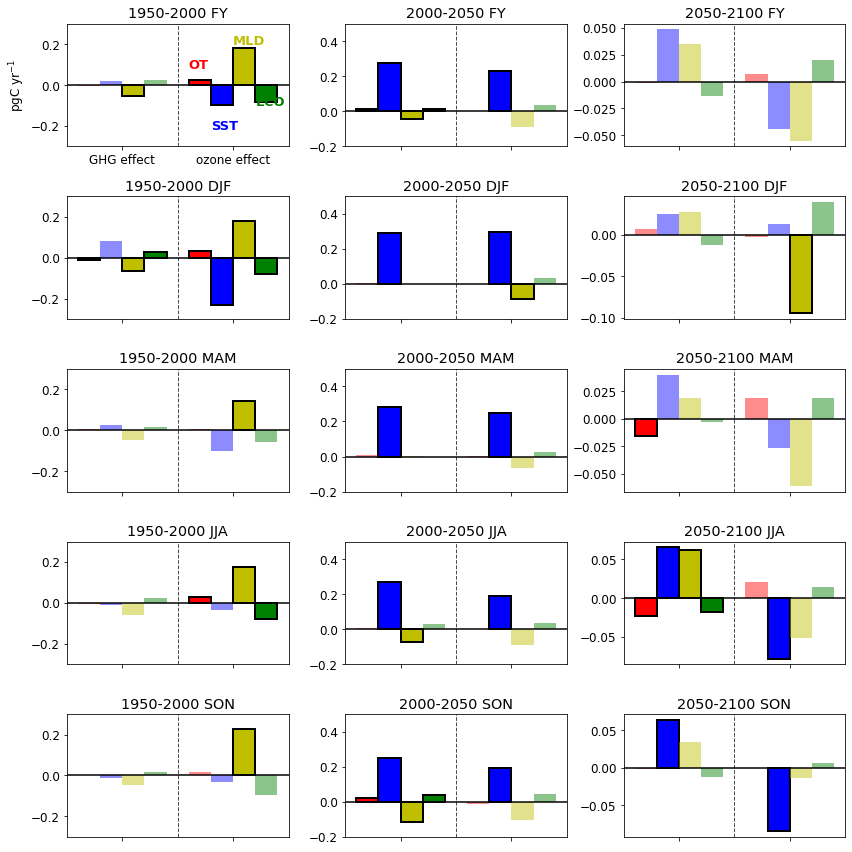

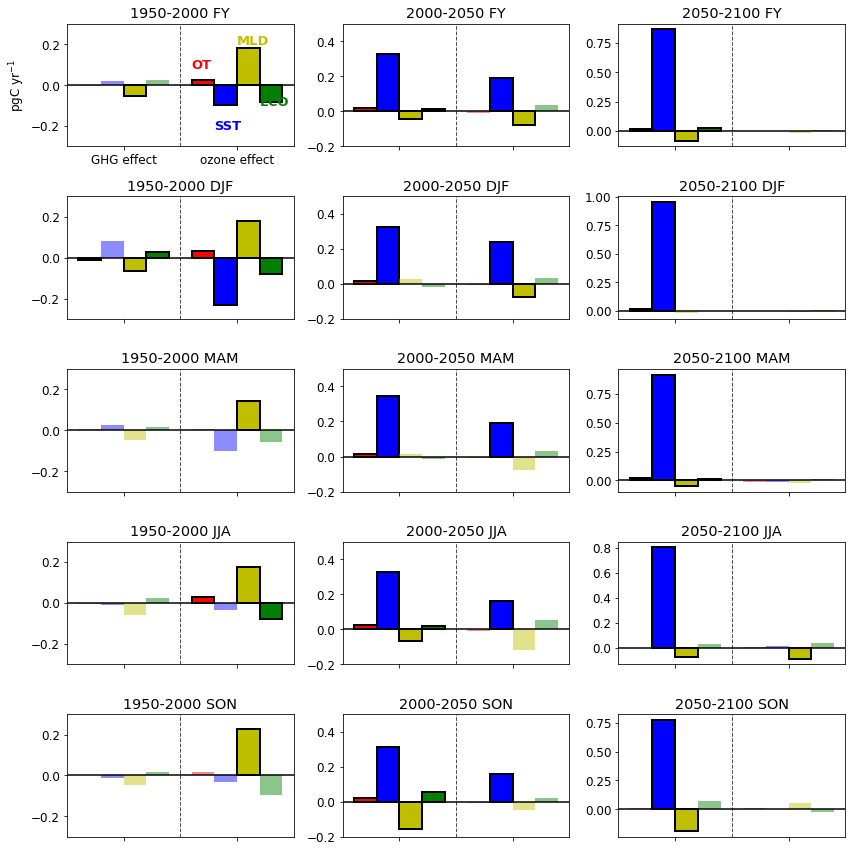

In [17]:
output_str = './data/BOE-inputs/BOE-OUTPUT-CLQtest.nc'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-CLQtest-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)
tssp = 'ssp3'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-CLQtest-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)

saved figure at ./data/BOE-inputs/BOE-OUTPUT-MEDUSA-ssp1.jpg
saved figure at ./data/BOE-inputs/BOE-OUTPUT-MEDUSA-ssp3.jpg


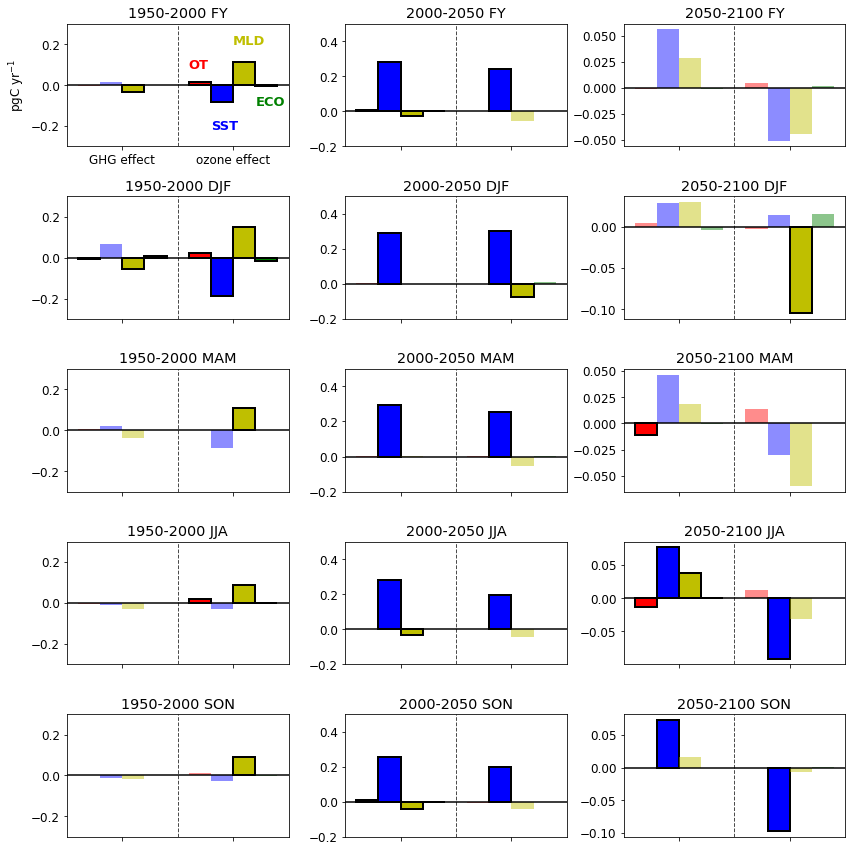

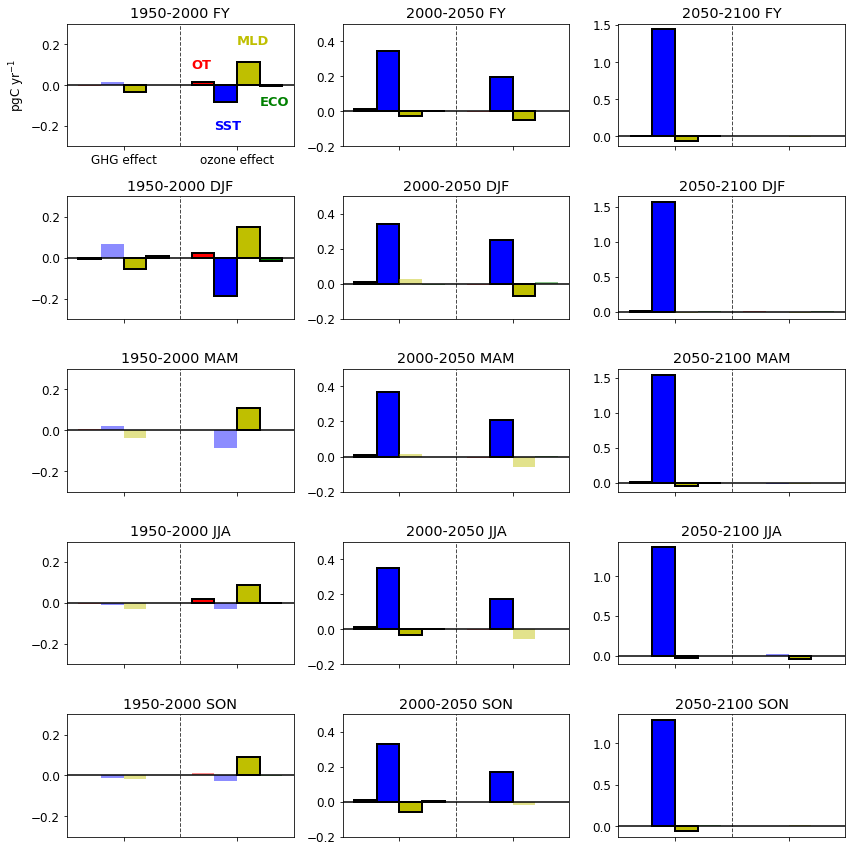

In [18]:
output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA.nc'
tssp = 'ssp1'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-MEDUSA-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)
tssp = 'ssp3'; 
fnam_str = f'./data/BOE-inputs/BOE-OUTPUT-MEDUSA-{tssp}.jpg'
make_boe_summary_graph_one_ssp_slide(output_str, fnam_str, tssp, valuedesc, True)

## overturning

In [19]:
import xarray as xr

changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
changes = xr.open_dataset(changes_str)
input_str = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-CLQtest.nc')

ot_delta = changes.trend.loc[{'period':'1950-2000', 'season':'FY', 'quantity': 'ot', \
                      'forcing': 'ozone', 'scenario': 'ssp1' }].values *5 # / decade to / 50 yrs 

SO_area = 4.67e13


grad_DIC_surfdeep =\
input_str['grad_DIC_surfdeep'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 
mn_DIC =\
input_str['mn_DIC'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 
mn_pCO2 =\
input_str['mn_pCO2'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 
mn_Revfact =\
input_str['mn_Revfact'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 
mn_kg =\
input_str['mn_kg'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 
grad_dDICdz =\
input_str['grad_dDICdz'].loc[{'period':'1950-2000', 'season':'FY',\
                                    'scenario': 'ssp1' }].values 


print(f'{grad_DIC_surfdeep}, {mn_DIC}, {mn_pCO2}, {mn_Revfact}, {mn_kg}')

dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
print(dfco2_pgCyr_OT_DIC)
#dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr


###mld
mld_delta = changes.trend.loc[{'period':'1950-2000', 'season':'FY', 'quantity': 'ot', \
                      'forcing': 'ozone', 'scenario': 'ssp1' }].values *5 # / decade to / 50 yrs 

dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
print(f'change in gradient in DIC {dDIC}') #umol/L
print(dDIC*SO_area * 1e3) #umol in surf ocean because of this
#changes.sel(forcing = 'ozoze')
#changes.trend['ot']


#ot_delta



# dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
# dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
# dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
# dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
# dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 

120.0, 2120.0, 380.0, 14.0, 0.065


NameError: name 'PgC_mol' is not defined

In [ ]:
siy = 

In [ ]:
dDIC_umol_L = ot_delta * 1e6 * grad_DIC_surfdeep * 1000 / SO_area
print(dDIC_umol_L)

In [ ]:
dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31557600 * 1e-6 ## extra umol in ocean

In [ ]:
print(dDIC_mol_yr)
print(dDIC_mol_yr*1e6)
print(dDIC_mol_yr * PgC_mol)

In [ ]:
24*60*60*365.25

In [ ]:
dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001  #L/m3 * mol/umol * sec/yr
dDIC_mol_per_m2 = dDIC_mol_yr/SO_area
dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mol_per_m2 #dpCO2 = R x pCO2/DIC x dDIC, ppm
dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
print(dfco2_pgCyr_OT_DIC)

In [ ]:
dDIC_mmol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000 #*31560000 #*0.000001  #L/m3 * mol/umol * sec/yr


dDIC_mmol_per_m3 = dDIC_mmol_yr/SO_area#/1000 #mol m3
dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_mmol_per_m3 #* 1000 #mmol/m3 #dpCO2 = R x pCO2/DIC x dDIC, ppm

dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
dfco2_pgCyr_OT_DIC = dfCO2_DIC * PgC_mol * SO_area 
print(dfco2_pgCyr_OT_DIC)

In [ ]:
dDIC_mol_yr = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001 / SO_area #L/m3 * mol/umol * sec/yr
dDIC_mol_yr2 = ot_delta * 1e6 * grad_DIC_surfdeep * 1000 / SO_area

In [ ]:
print(dDIC_mol_yr)
print(dDIC_mol_yr2)

In [ ]:
ot_delta